## Convocatoria 1 - Proyecto 1

## Estudiante: Luis Enrique Sánchez Zamora
## github: https://github.com/sanieni6/05MIAR

#### 0) Cargar una de las imágenes histológicas

In [18]:
# Imports
import skimage.io as ski
import matplotlib.pyplot as plt
import numpy as np
import cv2

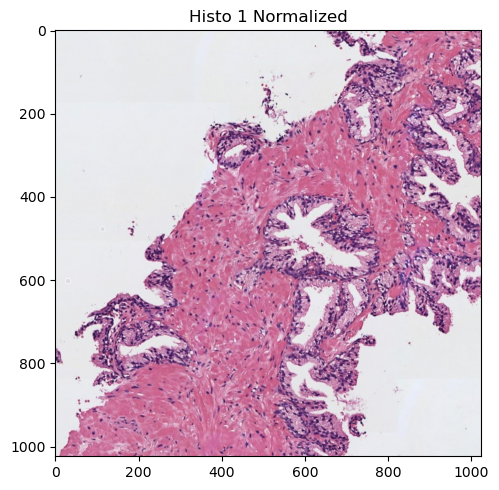

In [47]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.

histo_1 = ski.imread('histo_1.jpg')

# img_rgb_1 = cv2.cvtColor(histo_1, cv2.COLOR_BGR2RGB)

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Para imágenes, simplemente dividimos por 255 ya que los valores van de 0 a 255
histo_1_norm = histo_1.astype(float) / 255.0

# print(histo_1_norm)

# Visualizar la imagen
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(histo_1_norm)
plt.title('Histo 1 Normalized')

plt.tight_layout()
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

<Figure size 1200x500 with 0 Axes>

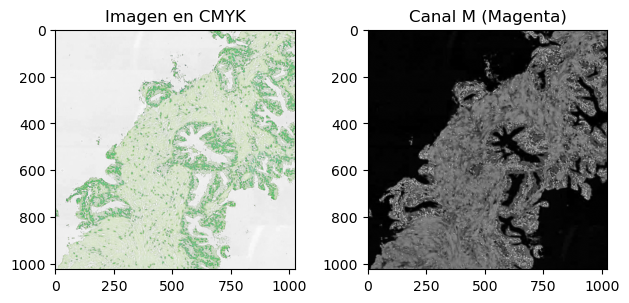

In [48]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)

def convert_to_CMYK(img):
    # Calcular el canal K
    K = 1 - np.max(img, axis=2)

    # Evitar división por cero añadiendo un pequeño valor epsilon
    epsilon = 1e-10
    K_safe = np.where(K == 1, 1 - epsilon, K)

    # Calcular el canal C
    C = (1-img[...,2] - K)/(1-K_safe)

    # Calcular el canal M
    M = (1-img[...,1] - K)/(1-K_safe)

    # Calcular el canal Y
    Y = (1-img[...,0] - K)/(1-K_safe)
    
    # Asegurar que los valores estén en el rango [0,1]
    C = np.clip(C, 0, 1)
    M = np.clip(M, 0, 1)
    Y = np.clip(Y, 0, 1)
    K = np.clip(K, 0, 1)
    
    # Combinar los canales C, M, Y y K en una imagen y reescalar los valores a uint8
    CMYK = (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)

    return CMYK

# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
img_cmyk = convert_to_CMYK(histo_1_norm)  # Usar la imagen normalizada
C,M,Y,K = cv2.split(img_cmyk)

# Visualizar la imagen del canal magenta
plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_cmyk.astype('uint8'))
ax[0].set_title('Imagen en CMYK')
# ax[0].axis('off')

ax[1].imshow(M.astype('uint8'), cmap='gray')
ax[1].set_title('Canal M (Magenta)')
# ax[1].axis('off')

plt.tight_layout()
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

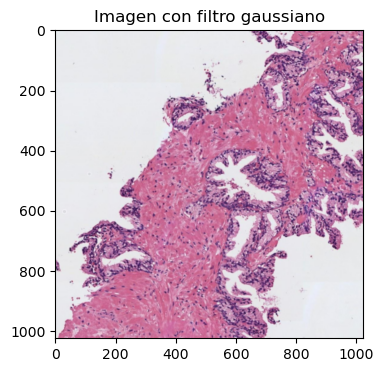

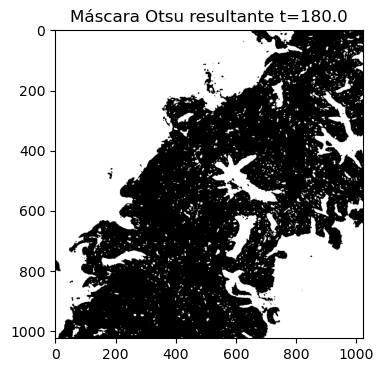

In [49]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

# usamos la imagen en formato RGB convertida a uint8
rgb_img = histo_1.astype('uint8')

# Aplicamos un filtro gaussiano de tamaño 5x5
blurred_img = cv2.GaussianBlur(rgb_img, (5, 5), 0)

gray_blurred_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6, 4))
plt.imshow(blurred_img)
plt.title('Imagen con filtro gaussiano')
plt.show()

# Aplicamos el método de Otsu
ret, otsu_mask = cv2.threshold(gray_blurred_img, 0, 1, cv2.THRESH_OTSU)

# Visualizamos la máscara resultante
plt.figure(figsize=(6, 4))
plt.imshow(otsu_mask, cmap='gray')
plt.title('Máscara Otsu resultante t={}'.format(ret))
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

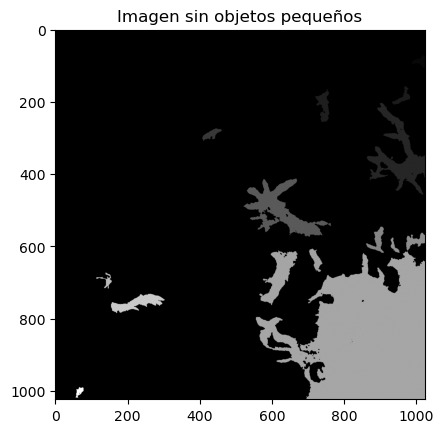

In [50]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
from skimage import morphology, measure

label_mask = measure.label(otsu_mask, connectivity=2)

# print(labeled_mask_ots)

area_threshold = 300
mask_removed = morphology.remove_small_objects(label_mask, min_size=area_threshold)
# Visualizaer la máscara resultante

plt.imshow(mask_removed, cmap='gray')
plt.title('Imagen sin objetos pequeños')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

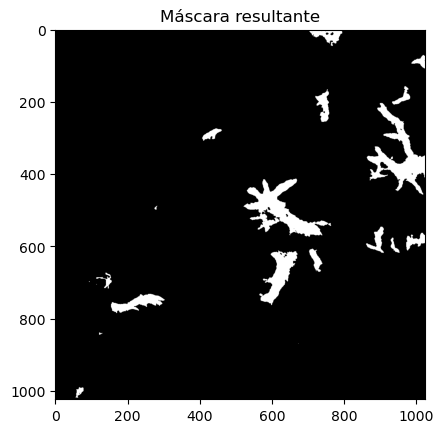

In [51]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

copy_img = otsu_mask.copy()

seed_1 = (0, 0)
seed_2 = (1000, 1000)

# creamos una máscara de ceros

h, w = copy_img.shape

zeros_mask = np.zeros((h + 2, w + 2), dtype=np.uint8)

# aplicamos el algoritmo de expansión a partir de semillas

mask_growing = cv2.floodFill(copy_img, zeros_mask, seed_1, 0)
mask_growing = cv2.floodFill(copy_img, zeros_mask, seed_2, 0)

# convertimos la máscara a binaria

binary_mask = mask_removed > 0

# aplicamos la máscara a la imagen original

mask_growing_img = np.zeros_like(copy_img)

mask_growing_img[binary_mask] = copy_img[binary_mask]

# visualizamos la máscara resultante

plt.imshow(mask_growing_img, cmap='gray')
plt.title('Máscara resultante')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

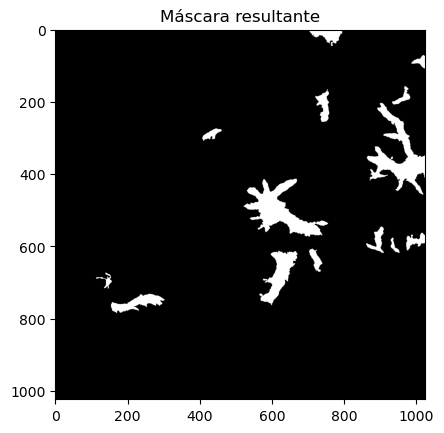

In [52]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label

# Visualizar la máscara resultante

filled_img = binary_fill_holes(mask_growing_img)

# aun son visible algunos puntos en la imagen, por lo que podemos aplicar de nuevo remove_small_objects con un area mayor

area_threshold = 370

total_lumen_cleaned = morphology.remove_small_objects(filled_img, min_size=area_threshold)

plt.imshow(total_lumen_cleaned, cmap='gray')
plt.title('Máscara resultante')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

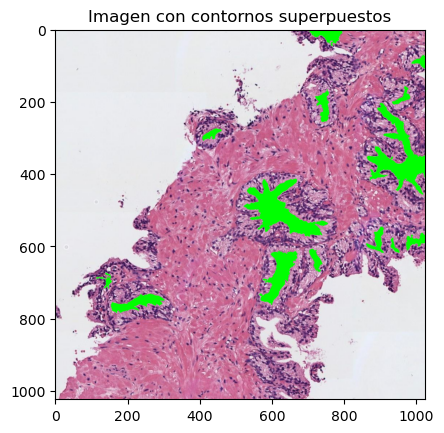

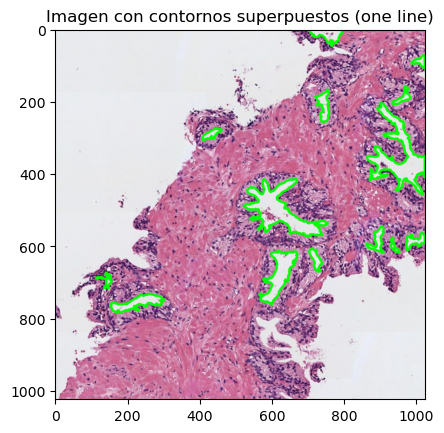

In [53]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.

#

img_rgb_contours = histo_1.copy()
img_rgb_contours[total_lumen_cleaned == 1] = [0, 255, 0]

plt.imshow(img_rgb_contours)
plt.title('Imagen con contornos superpuestos')
plt.show()

# visualizar one line contours

img_rgb_linear_contours = histo_1.copy()

contourned_img = total_lumen_cleaned.astype(np.uint8)

contours, _ = cv2.findContours(contourned_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img_rgb_linear_contours, contours, -1, (0, 255, 0), 5)

plt.imshow(img_rgb_linear_contours)
plt.title('Imagen con contornos superpuestos (one line)')
plt.show()


#### 7) Identificar y cropear el lumen más grande

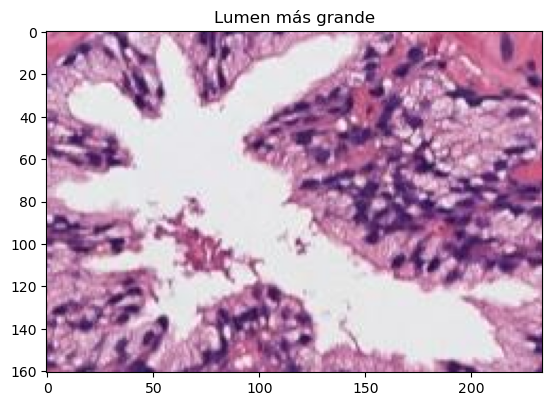

In [54]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.

# Importar la librería skimage.measure
from skimage import measure

# Obtener las etiquetas de los objetos en la máscara binaria
label_mask = measure.label(total_lumen_cleaned)

# Obtener el área de cada objeto
areas = measure.regionprops(label_mask)

# Visualizar el lumen cropeado.

# Encontrar el lumen con el área más grande
largest_lumen = max(areas, key=lambda x: x.area)

# Obtener las coordenadas del lumen más grande
y1, x1, y2, x2 = largest_lumen.bbox

# Hacer un crop de la imagen original RGB
cropped_image = histo_1[y1:y2, x1:x2]

# Visualizar el lumen cropeado
plt.imshow(cropped_image)
plt.title('Lumen más grande')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [55]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.

import math
import pandas as pd

# 1) Área
area = round(largest_lumen.area, 4)
print(f"1) Área: {area}")

# 2) Área de la bounding box
bbox_area = round(largest_lumen.bbox_area, 4)
print(f"2) Área de la bounding box: {bbox_area}")

# 3) Área convexa
convex_area = round(largest_lumen.convex_area, 4)
print(f"3) Área convexa: {convex_area}")

# 4) Excentricidad
eccentricity = round(largest_lumen.eccentricity, 4)
print(f"4) Excentricidad: {eccentricity}")

# 5) Diámetro equivalente
equivalent_diameter = round(largest_lumen.equivalent_diameter, 4)
print(f"5) Diámetro equivalente: {equivalent_diameter}")

# 6) Extensión (Extent)
extent = round(largest_lumen.extent, 4)
print(f"6) Extensión: {extent}")

# 7) Diámetro Feret
feret_diameter_max = round(largest_lumen.feret_diameter_max, 4)
print(f"7) Diámetro Feret: {feret_diameter_max}")

# 8) Longitud del eje mayor
major_axis_length = round(largest_lumen.major_axis_length, 4)
print(f"8) Longitud del eje mayor: {major_axis_length}")

# 9) Longitud del eje menor
minor_axis_length = round(largest_lumen.minor_axis_length, 4)
print(f"9) Longitud del eje menor: {minor_axis_length}")

# 10) Orientación
orientation = round(largest_lumen.orientation, 4)
print(f"10) Orientación: {orientation}")

# 11) Perímetro
perimeter = round(largest_lumen.perimeter, 4)
print(f"11) Perímetro: {perimeter}")

# 12) Solidez
solidity = round(largest_lumen.solidity, 4)
print(f"12) Solidez: {solidity}")

# 13) Compacidad (Compactness = 4π * area / perimeter²)
compactness = round((4 * math.pi * largest_lumen.area) / (largest_lumen.perimeter ** 2), 4)
print(f"13) Compacidad: {compactness}")


1) Área: 13388.0
2) Área de la bounding box: 37674.0
3) Área convexa: 27468.0
4) Excentricidad: 0.8443
5) Diámetro equivalente: 130.5608
6) Extensión: 0.3554
7) Diámetro Feret: 243.4625
8) Longitud del eje mayor: 231.6393
9) Longitud del eje menor: 124.1365
10) Orientación: 0.9969
11) Perímetro: 1163.6266
12) Solidez: 0.4874
13) Compacidad: 0.1243


In [56]:
# Crear un DataFrame con todas las propiedades para una visualización organizada
properties_data = {
    'Propiedad': [
        'Área', 
        'Área de la bounding box', 
        'Área convexa', 
        'Excentricidad',
        'Diámetro equivalente', 
        'Extensión', 
        'Diámetro Feret', 
        'Longitud del eje mayor', 
        'Longitud del eje menor', 
        'Orientación',
        'Perímetro', 
        'Solidez', 
        'Compacidad'
    ],
    'Valor': [
        area, 
        bbox_area, 
        convex_area, 
        eccentricity, 
        equivalent_diameter,
        extent, 
        feret_diameter_max, 
        major_axis_length, 
        minor_axis_length,
        orientation, 
        perimeter, 
        solidity, 
        compactness
    ]
}

properties_df = pd.DataFrame(properties_data)

# Mostrar la tabla
print("TABLA COMPLETA DE PROPIEDADES GEOMÉTRICAS")
print("="*40)
print(properties_df.to_string(index=False, max_colwidth=35))


TABLA COMPLETA DE PROPIEDADES GEOMÉTRICAS
              Propiedad      Valor
                   Área 13388.0000
Área de la bounding box 37674.0000
           Área convexa 27468.0000
          Excentricidad     0.8443
   Diámetro equivalente   130.5608
              Extensión     0.3554
         Diámetro Feret   243.4625
 Longitud del eje mayor   231.6393
 Longitud del eje menor   124.1365
            Orientación     0.9969
              Perímetro  1163.6266
                Solidez     0.4874
             Compacidad     0.1243
